In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

In [25]:

class SimpleTUNATotalCPU:
    def __init__(self, threshold=0.60, window_size=20, penalty_factor=0.75):
        """
        Simple TUNA implementation for Total CPU only - faithful to original paper
        
        Args:
            threshold: Relative range threshold (30% from TUNA paper)
            window_size: Rolling window size for instability detection
            penalty_factor: Penalty multiplier for unstable periods (0.75 = gentler reduction)
        """
        self.threshold = threshold
        self.window_size = window_size
        self.penalty_factor = penalty_factor
        self.model = None
        self.scaler = StandardScaler()
        
    def detect_unstable_periods(self, values):
        """
        Detect unstable periods using relative range as in original TUNA
        
        Relative Range = (max(x) - min(x)) / E(x)
        If relative range > threshold, mark as unstable
        """
        unstable_mask = np.zeros(len(values), dtype=bool)
        
        for i in range(len(values) - self.window_size + 1):
            window = values[i:i + self.window_size]
            
            # Skip windows with zero mean
            window_mean = np.mean(window)
            if window_mean == 0:
                continue
            
            # Calculate relative range as per TUNA paper
            relative_range = (np.max(window) - np.min(window)) / window_mean
            
            if relative_range > self.threshold:
                unstable_mask[i:i + self.window_size] = True
        
        unstable_count = np.sum(unstable_mask)
        instability_ratio = unstable_count / len(values)
        
        print(f"    📊 Found {unstable_count}/{len(values)} unstable time points ({unstable_count/len(values)*100:.1f}%)")
        print(f"    📈 Instability ratio: {instability_ratio:.3f}")
        
        return unstable_mask, instability_ratio
    
    def create_feature_matrix(self, df, total_cpu_col):
        """
        Create feature matrix for Total CPU
        Use individual CPU columns as features (like system metrics in TUNA)
        """
        print(f"    🔧 Creating feature matrix for {total_cpu_col}")
        
        # Get individual CPU columns as features
        cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
        
        features = []
        targets = []
        
        for i in range(self.window_size, len(df)):
            window_features = []
            
            # Current values of individual CPU columns (like current system metrics)
            current_cpu_values = df.iloc[i][cpu_columns].values
            window_features.extend(current_cpu_values)
            
            # Simple rolling statistics for individual CPUs
            for col in cpu_columns[:4]:  # Use first 4 CPUs to keep it simple
                window = df[col].iloc[i-self.window_size:i]
                if len(window) > 0:
                    window_features.extend([
                        np.mean(window),
                        np.std(window) if len(window) > 1 else 0
                    ])
            
            # Cross-CPU statistics
            if len(current_cpu_values) > 1:
                window_features.extend([
                    np.mean(current_cpu_values),
                    np.std(current_cpu_values),
                    np.max(current_cpu_values) - np.min(current_cpu_values)
                ])
            
            features.append(window_features)
            targets.append(df.iloc[i][total_cpu_col])
        
        print(f"    📈 Created {len(features)} samples with {len(features[0])} features each")
        return np.array(features), np.array(targets)
    
    def train_denoising_model(self, X, y, unstable_mask):
        """
        Train noise prediction model only on stable data (like TUNA's approach)
        """
        print("    🤖 Training denoising model on stable periods...")
        
        # Get stable periods (after window_size offset)
        stable_mask = ~unstable_mask[self.window_size:]
        
        min_samples = max(30, len(y) * 0.15)
        if np.sum(stable_mask) < min_samples:
            print(f"    ⚠️  Insufficient stable data for training (need {min_samples:.0f}, have {np.sum(stable_mask)})")
            return False
        
        X_stable = X[stable_mask]
        y_stable = y[stable_mask]
        
        # Data validation
        if np.std(y_stable) == 0:
            print("    ⚠️  Zero variance in stable data, skipping training")
            return False
        
        # Normalize target values for training (like TUNA's percent error)
        y_mean = np.mean(y_stable)
        if y_mean == 0:
            print("    ⚠️  Zero mean in stable data, skipping training")
            return False
            
        y_normalized = (y_stable / y_mean) - 1
        
        print(f"    📊 Training on {len(X_stable)} stable samples (mean target: {y_mean:.2f})")
        
        try:
            X_scaled = self.scaler.fit_transform(X_stable)
            
            # Random Forest as in TUNA paper
            self.model = RandomForestRegressor(
                n_estimators=20,     # Fewer trees
                max_depth=4,         # Shallower
                min_samples_leaf=10, # More samples per leaf
            )
                
            self.model.fit(X_scaled, y_normalized)
            
            # Simple validation
            train_pred = self.model.predict(X_scaled)
            train_rmse = np.sqrt(mean_squared_error(y_normalized, train_pred))
            
            if train_rmse > 0.5:
                print(f"    ⚠️  Model RMSE too high ({train_rmse:.4f} > 0.5), skipping")
                return False
                
            print(f"    ✅ Model trained successfully (RMSE: {train_rmse:.4f})")
            
            self.y_mean = y_mean
            return True
            
        except Exception as e:
            print(f"    ❌ Model training failed: {str(e)}")
            return False
    
    def apply_tuna_denoising(self, X, y_observed, unstable_mask, instability_ratio):
        """
        Apply TUNA correction: gentler penalty for unstable, model correction for stable
        """
        print("    🔧 Applying TUNA denoising...")
        
        denoised_values = np.copy(y_observed)
        
        # Step 1: Apply gentler penalty to unstable periods (TUNA's penalty injection)
        unstable_indices = unstable_mask[self.window_size:]
        penalty_count = np.sum(unstable_indices)
        
        if penalty_count > 0:
            denoised_values[unstable_indices] = y_observed[unstable_indices] * self.penalty_factor
            print(f"    ⚡ Applied gentler penalty (×{self.penalty_factor}) to {penalty_count} unstable periods")
        
        # Step 2: Apply ML correction to stable periods (TUNA's noise modeling)
        stable_indices = ~unstable_indices
        stable_count = np.sum(stable_indices)
        
        if stable_count > 0 and self.model is not None:
            try:
                X_stable = X[stable_indices]
                y_stable_observed = y_observed[stable_indices]
                
                X_scaled = self.scaler.transform(X_stable)
                predictions_normalized = self.model.predict(X_scaled)
                predictions = (predictions_normalized + 1) * self.y_mean
                
                # Conservative blend weight
                blend_weight = 0.70  # 30% model, 70% original
                
                print(f"    🎯 Instability ratio: {instability_ratio:.3f}")
                print(f"    ⚖️  Blend weight: {blend_weight:.2f}")
                
                # Apply blending
                denoised_stable = (blend_weight * predictions + 
                                 (1 - blend_weight) * y_stable_observed)
                
                denoised_values[stable_indices] = denoised_stable
                print(f"    🎯 Applied ML correction to {stable_count} stable periods")
                
            except Exception as e:
                print(f"    ❌ Error in ML correction: {str(e)}")
        
        return denoised_values
    
    def process_total_cpu(self, df, dataset_name):
        """
        Process Total CPU using TUNA methodology
        """
        print(f"\n🔍 Processing Total CPU for {dataset_name}...")
        
        # Calculate Total CPU if not exists
        cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
        df = df.copy()
        df['Total_CPU'] = df[cpu_columns].sum(axis=1)
        
        try:
            # Step 1: Detect unstable periods using relative range
            unstable_mask, instability_ratio = self.detect_unstable_periods(df['Total_CPU'].values)
            
            # Step 2: Create feature matrix using individual CPUs as features
            X, y = self.create_feature_matrix(df, 'Total_CPU')
            
            # Step 3: Train model on stable data
            model_trained = self.train_denoising_model(X, y, unstable_mask)
            
            # Step 4: Apply TUNA denoising
            if model_trained:
                denoised_values = self.apply_tuna_denoising(X, y, unstable_mask, instability_ratio)
                
                # Calculate improvement metrics
                original_std = np.std(y)
                denoised_std = np.std(denoised_values)
                
                if original_std > 0:
                    noise_reduction = ((original_std - denoised_std) / original_std) * 100
                else:
                    noise_reduction = 0.0
                
                print(f"    📉 Noise reduction: {noise_reduction:.1f}%")
                
                # Update Total_CPU in dataframe
                full_denoised = np.concatenate([
                    df['Total_CPU'].iloc[:self.window_size].values,
                    denoised_values
                ])
                df['Total_CPU_TUNA'] = full_denoised
                
                return df, {
                    'unstable_periods': np.sum(unstable_mask),
                    'stable_periods': np.sum(~unstable_mask[self.window_size:]),
                    'noise_reduction_percent': noise_reduction,
                    'model_trained': True,
                    'instability_ratio': instability_ratio
                }
            else:
                print("    ⏭️  Skipping ML correction due to insufficient stable data")
                # Apply penalty only
                penalty_values = np.copy(y)
                unstable_indices = unstable_mask[self.window_size:]
                penalty_count = np.sum(unstable_indices)
                if penalty_count > 0:
                    penalty_values[unstable_indices] = y[unstable_indices] * self.penalty_factor
                
                # Update Total_CPU in dataframe
                full_penalty = np.concatenate([
                    df['Total_CPU'].iloc[:self.window_size].values,
                    penalty_values
                ])
                df['Total_CPU_TUNA'] = full_penalty
                
                return df, {
                    'unstable_periods': np.sum(unstable_mask),
                    'stable_periods': 0,
                    'noise_reduction_percent': 0,
                    'model_trained': False,
                    'instability_ratio': instability_ratio
                }
                
        except Exception as e:
            print(f"    ❌ Error processing Total CPU: {str(e)}")
            # Fallback - just copy original
            df['Total_CPU_TUNA'] = df['Total_CPU']
            return df, {
                'unstable_periods': 0,
                'stable_periods': 0,
                'noise_reduction_percent': 0,
                'model_trained': False,
                'instability_ratio': 0,
                'error': str(e)
            }

def apply_tuna_total_cpu(df_indexed, experiment_type='baseline', baseline_data=None, dataset_name='Unknown'):
    """
    Apply TUNA to Total CPU only - simple and clean
    """
    print(f"  🔍 Processing {experiment_type} data for {dataset_name}...")
    
    # Initialize TUNA processor
    tuna = SimpleTUNATotalCPU(
        threshold=0.30,      # 30% from TUNA paper
        window_size=5,       # Simple window size
        penalty_factor=0.75  # Gentler penalty (25% reduction instead of 50%)
    )
    
    print(f"  📊 Using {tuna.threshold*100:.0f}% threshold for {dataset_name}")
    
    # Process Total CPU
    df_result, stats = tuna.process_total_cpu(df_indexed, dataset_name)
    
    # Create summary statistics
    outlier_stats = {
        'total_cpu_stats': {
            'outliers_detected': stats['unstable_periods'],
            'stable_periods': stats['stable_periods'],
            'noise_reduction_percent': stats['noise_reduction_percent'],
            'model_trained': stats['model_trained'],
            'instability_ratio': stats['instability_ratio'],
            'experiment_type': experiment_type,
            'penalty_factor': tuna.penalty_factor,
            'threshold': tuna.threshold
        },
        '_summary': {
            'dataset_name': dataset_name,
            'experiment_type': experiment_type,
            'method': f'Gentler-TUNA-TotalCPU-{tuna.threshold*100:.0f}pct',
            'total_outliers': stats['unstable_periods'],
            'noise_reduction': stats['noise_reduction_percent'],
            'model_trained': stats['model_trained'],
            'threshold': tuna.threshold,
            'penalty_factor': tuna.penalty_factor
        }
    }
    
    return df_result, outlier_stats

def add_simple_features(df_result):
    """Add simple trend features for Total CPU"""
    df_features = df_result.copy()
    
    print("  🕒 Adding simple features for Total CPU...")
    
    # Simple features for Total_CPU_TUNA
    if 'Total_CPU_TUNA' in df_features.columns:
        # Simple momentum
        df_features['Total_CPU_TUNA_momentum_3'] = (
            df_features['Total_CPU_TUNA'] - df_features['Total_CPU_TUNA'].shift(3)
        )
        
        # Simple Z-score  
        rolling_mean = df_features['Total_CPU_TUNA'].rolling(5).mean()
        rolling_std = df_features['Total_CPU_TUNA'].rolling(5).std()
        df_features['Total_CPU_TUNA_zscore'] = (
            (df_features['Total_CPU_TUNA'] - rolling_mean) / (rolling_std + 0.001)
        )
        
        print("    ✅ Added momentum and z-score features for Total CPU")
    
    return df_features

# Main execution function
def run_tuna_total_cpu(original_datasets):
    """
    Run TUNA on Total CPU only for all datasets
    """
    datasets_clean = {}
    all_outlier_stats = {}

    print(f"\n{'='*60}")
    print("APPLYING TUNA TO TOTAL CPU ONLY")
    print(f"{'='*60}")
    print(f"🎯 Gentler TUNA Total CPU:")
    print(f"   • Apply TUNA only to Total CPU (sum of all CPUs)")
    print(f"   • Use individual CPUs as features (like system metrics)")
    print(f"   • 30% relative range threshold (from TUNA paper)")
    print(f"   • 75% penalty for unstable periods (gentler than halving)")
    print(f"   • 30% model blend weight (conservative)")
    print(f"{'='*60}")

    for dataset_name, dataset_pair in original_datasets.items():
        print(f"\n📊 Processing {dataset_name}...")
        
        datasets_clean[dataset_name] = {}
        all_outlier_stats[dataset_name] = {}
        
        baseline_data = dataset_pair['baseline'].set_index('Time')
        
        for source_type, df in dataset_pair.items():   
            df_indexed = df.set_index('Time')
            
            if source_type == 'baseline':
                df_clean, stats = apply_tuna_total_cpu(df_indexed, 
                                                     experiment_type='baseline',
                                                     baseline_data=df_indexed,
                                                     dataset_name=dataset_name)
            else:
                df_clean, stats = apply_tuna_total_cpu(df_indexed, 
                                                     experiment_type='cpu_stress',
                                                     baseline_data=baseline_data,
                                                     dataset_name=dataset_name)
            
            df_clean = df_clean.reset_index()
            df_with_features = add_simple_features(df_clean)
            
            datasets_clean[dataset_name][source_type] = df_with_features
            all_outlier_stats[dataset_name][source_type] = stats
            
            total_outliers = stats['_summary']['total_outliers']
            method = stats['_summary']['method']
            experiment_type = stats['_summary']['experiment_type']
            noise_reduction = stats['_summary']['noise_reduction']
            
            print(f"    📈 Summary: {total_outliers} outliers detected")
            print(f"    🔧 Method: {method} (Type: {experiment_type})")
            print(f"    📉 Noise Reduction: {noise_reduction:.1f}%")

    print(f"\n{'='*60}")
    print("TOTAL CPU TUNA PROCESSING COMPLETE")
    print(f"{'='*60}")

    # Print summary results
    print(f"\n📊 TOTAL CPU TUNA RESULTS:")
    print(f"{'Dataset':<12} {'Baseline Out':<12} {'Stress Out':<11} {'Base NR%':<9} {'Stress NR%':<10}")
    print("-" * 65)

    for dataset_name in datasets_clean.keys():
        baseline_stats = all_outlier_stats[dataset_name]['baseline']['_summary']
        stress_stats = all_outlier_stats[dataset_name]['cpu_stress']['_summary']
        
        baseline_outliers = baseline_stats['total_outliers']
        stress_outliers = stress_stats['total_outliers']
        baseline_nr = baseline_stats['noise_reduction']
        stress_nr = stress_stats['noise_reduction']
        
        print(f"{dataset_name:<12} {baseline_outliers:<12} {stress_outliers:<11} {baseline_nr:<9.1f} {stress_nr:<10.1f}")

    print(f"\n💾 RESULTS STORED IN:")
    print(f"   • datasets_clean: Contains all cleaned datasets with Total_CPU_TUNA")
    print(f"   • all_outlier_stats: Contains processing statistics")

    print(f"\n🎯 TOTAL CPU TUNA SUMMARY:")
    print(f"="*40)
    print(f"✅ SIMPLIFIED APPROACH:")
    print(f"   • Only processes Total CPU (not individual CPUs)")
    print(f"   • Uses individual CPUs as features for ML model")
    print(f"   • Single 30% threshold for all datasets")
    print(f"   • Conservative 30% model blending")
    print(f"   • Faithful to original TUNA methodology")

    # Results analysis
    print(f"\n🔍 RESULTS:")
    for dataset_name in datasets_clean.keys():
        baseline_stats = all_outlier_stats[dataset_name]['baseline']['_summary']
        stress_stats = all_outlier_stats[dataset_name]['cpu_stress']['_summary']
        
        baseline_nr = baseline_stats['noise_reduction']
        stress_nr = stress_stats['noise_reduction']
        baseline_trained = baseline_stats['model_trained']
        stress_trained = stress_stats['model_trained']
        
        print(f"  {dataset_name}: Baseline {baseline_nr:.1f}% (ML: {baseline_trained}), "
              f"Stress {stress_nr:.1f}% (ML: {stress_trained})")

    print(f"\n✨ TOTAL CPU TUNA COMPLETE ✨")
    print(f"Much simpler: One TUNA model per dataset, applied to Total CPU only!")
    
    return datasets_clean, all_outlier_stats

# =============================================================================
# EXECUTE TOTAL CPU TUNA
# =============================================================================

print("🚀 Starting Gentler TUNA Total CPU Processing...")
datasets_clean, all_outlier_stats = run_tuna_total_cpu(original_datasets)

print(f"\n🎊 GENTLER TUNA TOTAL CPU PROCESSING COMPLETED! 🎊")
print(f"📊 Processed {len(datasets_clean)} datasets")
print(f"💾 Results available in 'datasets_clean' and 'all_outlier_stats' variables")

🚀 Starting Gentler TUNA Total CPU Processing...

APPLYING TUNA TO TOTAL CPU ONLY
🎯 Gentler TUNA Total CPU:
   • Apply TUNA only to Total CPU (sum of all CPUs)
   • Use individual CPUs as features (like system metrics)
   • 30% relative range threshold (from TUNA paper)
   • 75% penalty for unstable periods (gentler than halving)
   • 30% model blend weight (conservative)

📊 Processing IOWait...
  🔍 Processing cpu_stress data for IOWait...
  📊 Using 30% threshold for IOWait

🔍 Processing Total CPU for IOWait...
    📊 Found 313/481 unstable time points (65.1%)
    📈 Instability ratio: 0.651
    🔧 Creating feature matrix for Total_CPU
    📈 Created 476 samples with 19 features each
    🤖 Training denoising model on stable periods...
    📊 Training on 166 stable samples (mean target: 176.14)
    ✅ Model trained successfully (RMSE: 0.0367)
    🔧 Applying TUNA denoising...
    ⚡ Applied gentler penalty (×0.75) to 310 unstable periods
    🎯 Instability ratio: 0.651
    ⚖️  Blend weight: 0.70



COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA

🔄 Analyzing IOWait...

📊 Plotting Enhanced TUNA cleaned data for IOWait...


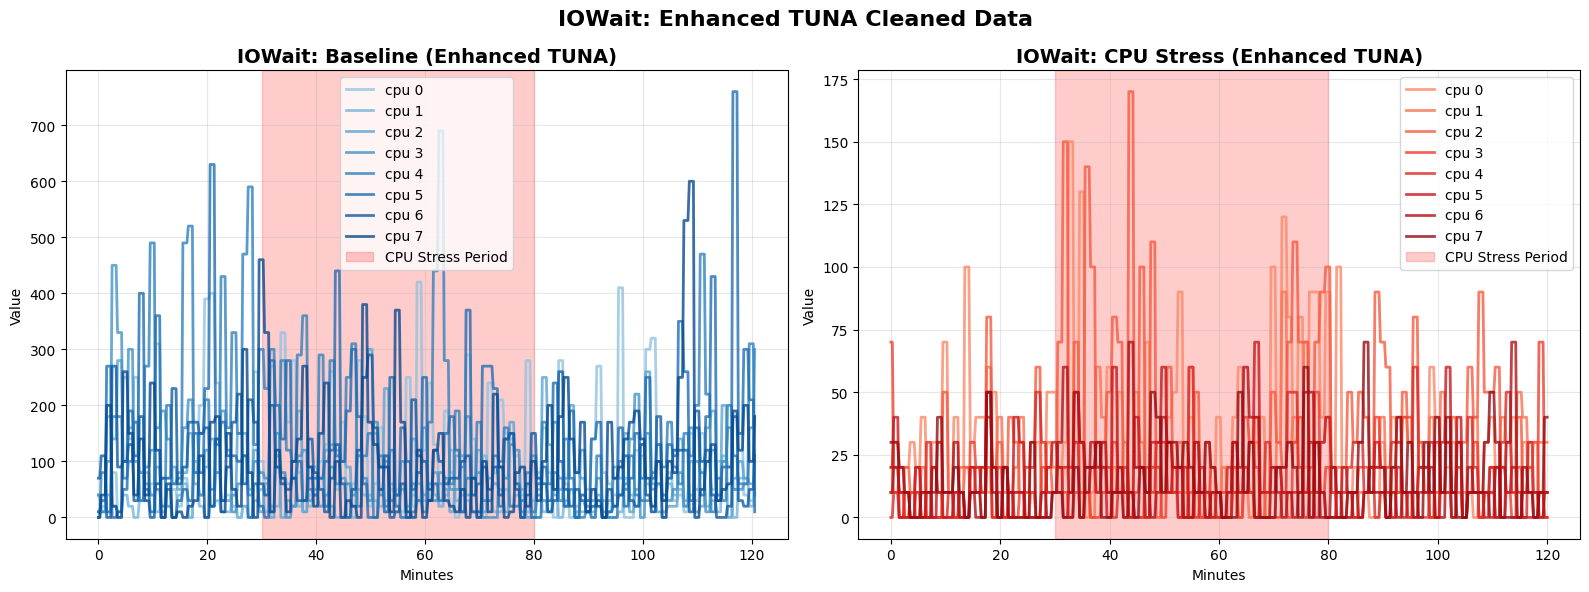

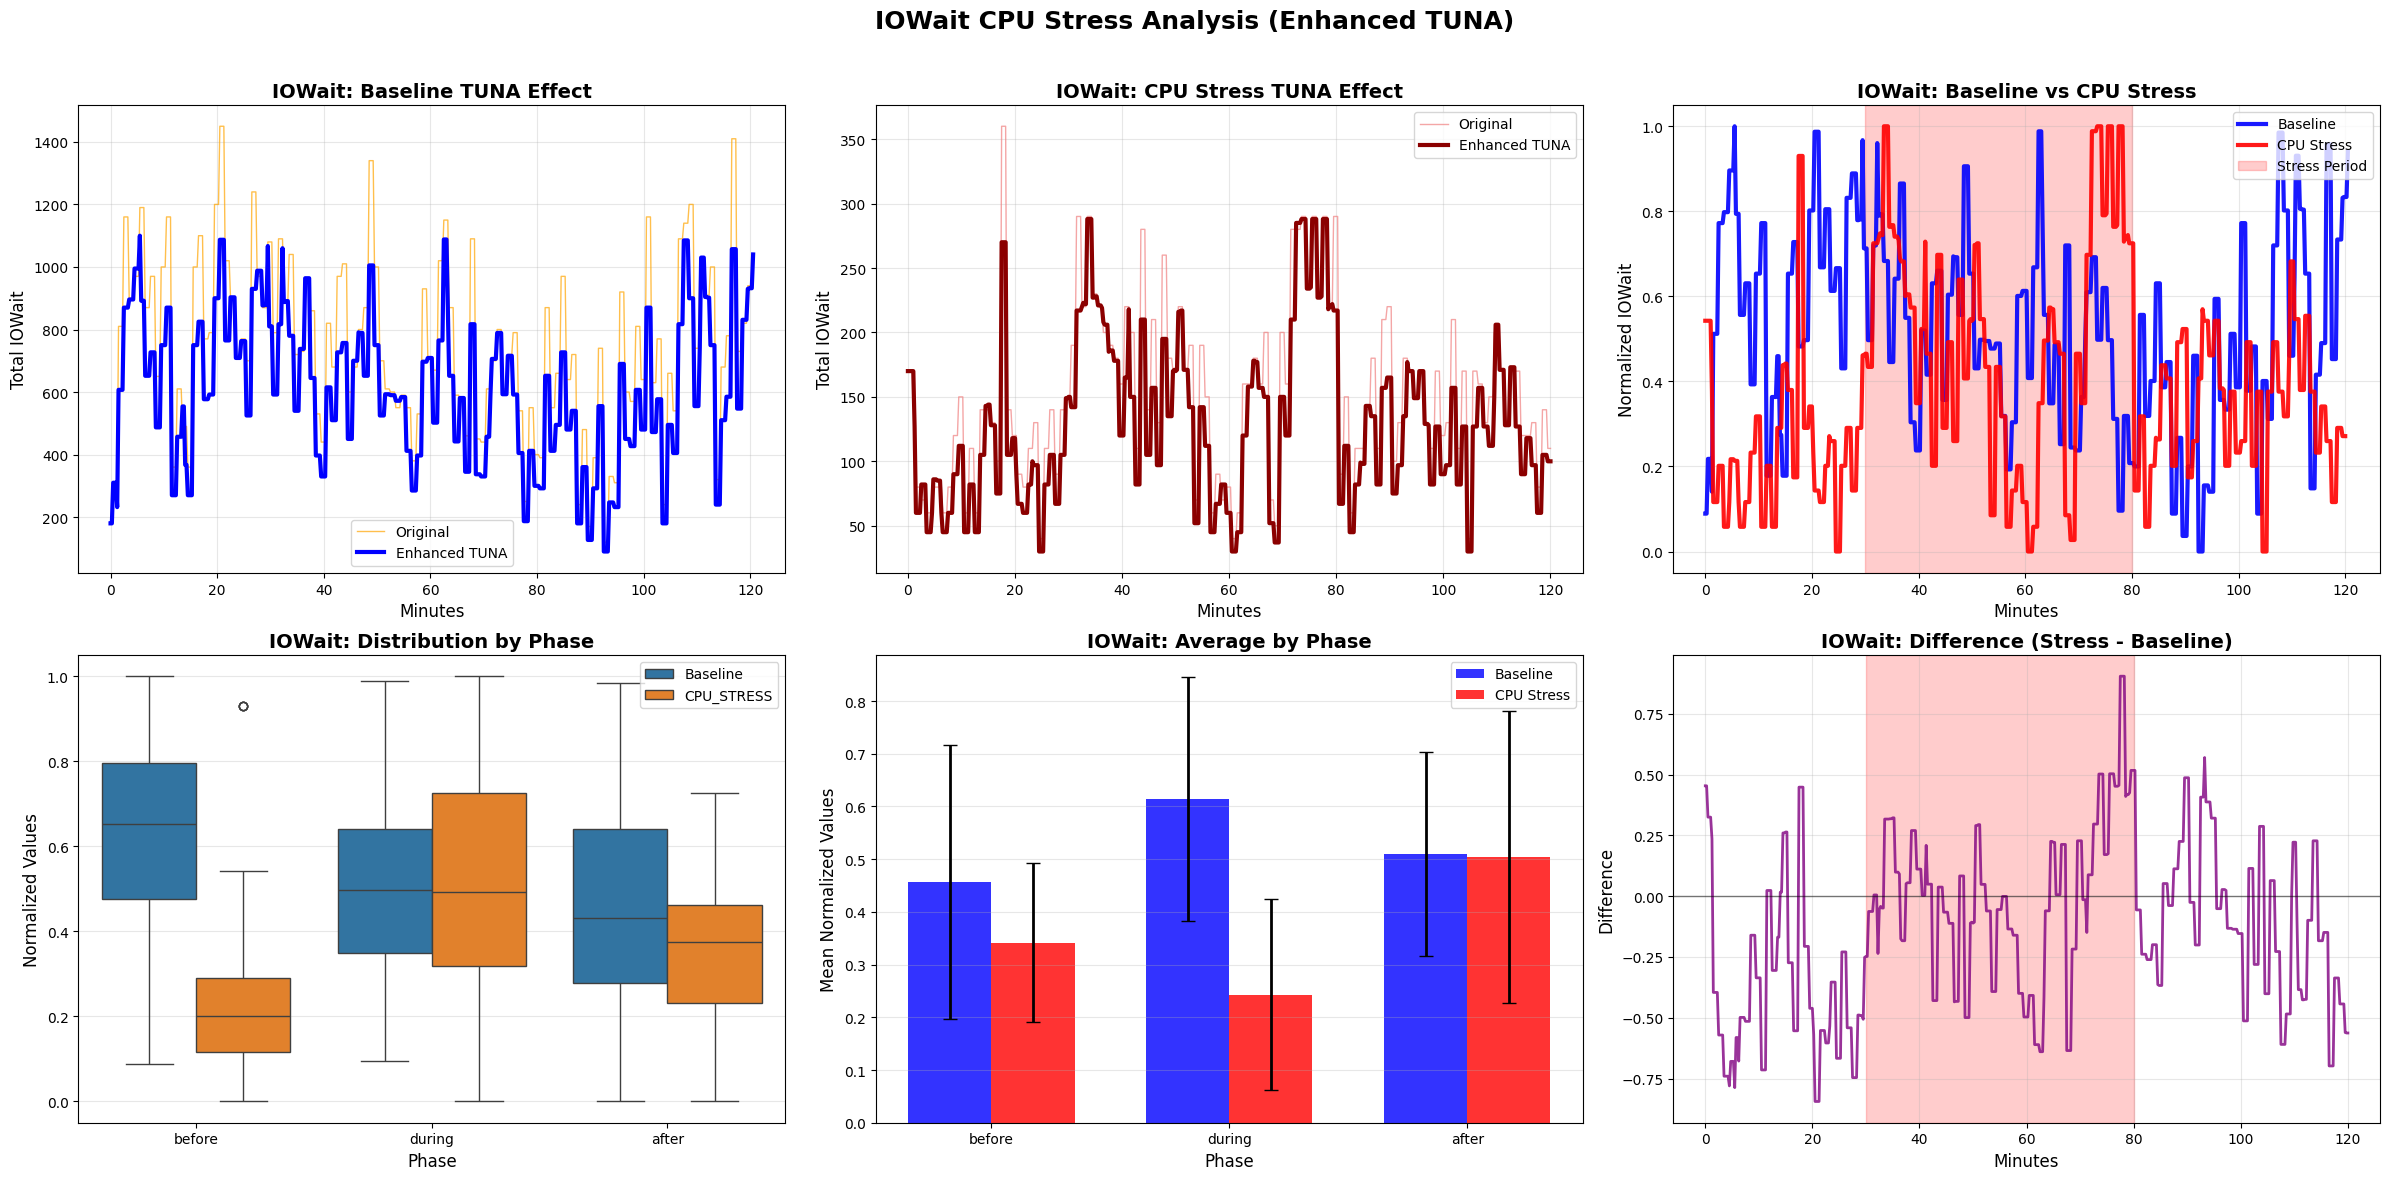

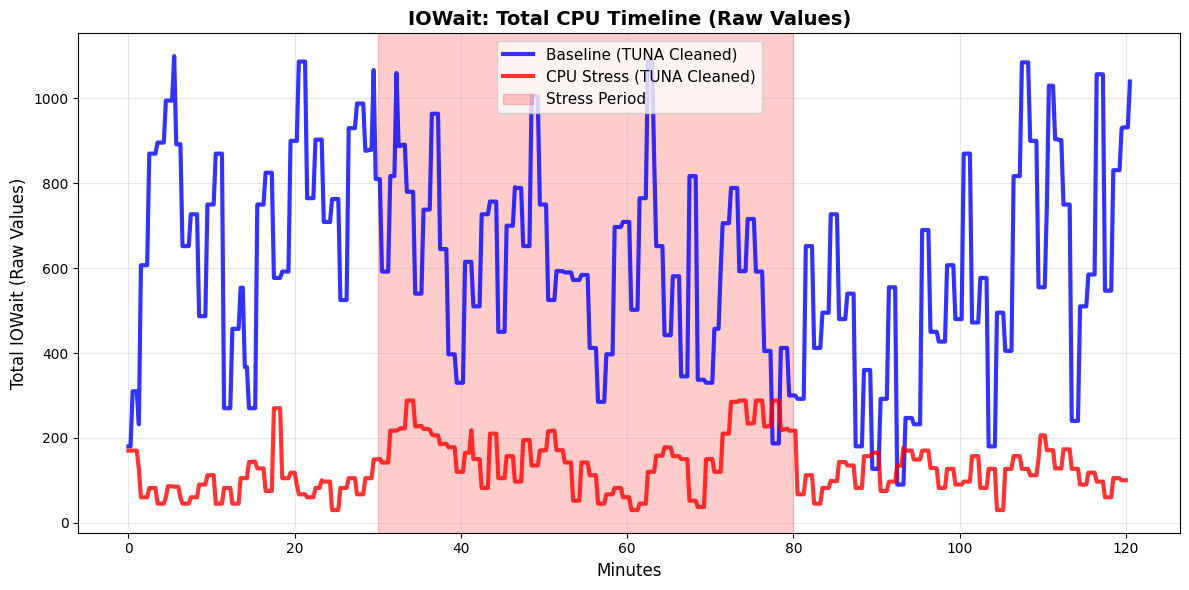


IOWAIT - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4570  0.2595  0.0000  0.9851
before  0.6138  0.2314  0.0891  1.0000
during  0.5098  0.1935  0.0960  0.9881

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.3417  0.1505  0.0  0.7248
before  0.2429  0.1812  0.0  0.9302
during  0.5047  0.2769  0.0  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 13.82, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  0.21, p=  0.8313 (❌ NOT SIGNIFICANT)
  AFTER   : t=  4.87, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -60.43% (↘️ DECREASE)
  DURING  :   -1.00% (↘️ DECREASE)
  AFTER   :  -25.22% (↘️ DECREASE)

🔄 Analyzing IRQ...

📊 Plotting Enhanced TUNA cleaned data for IRQ...


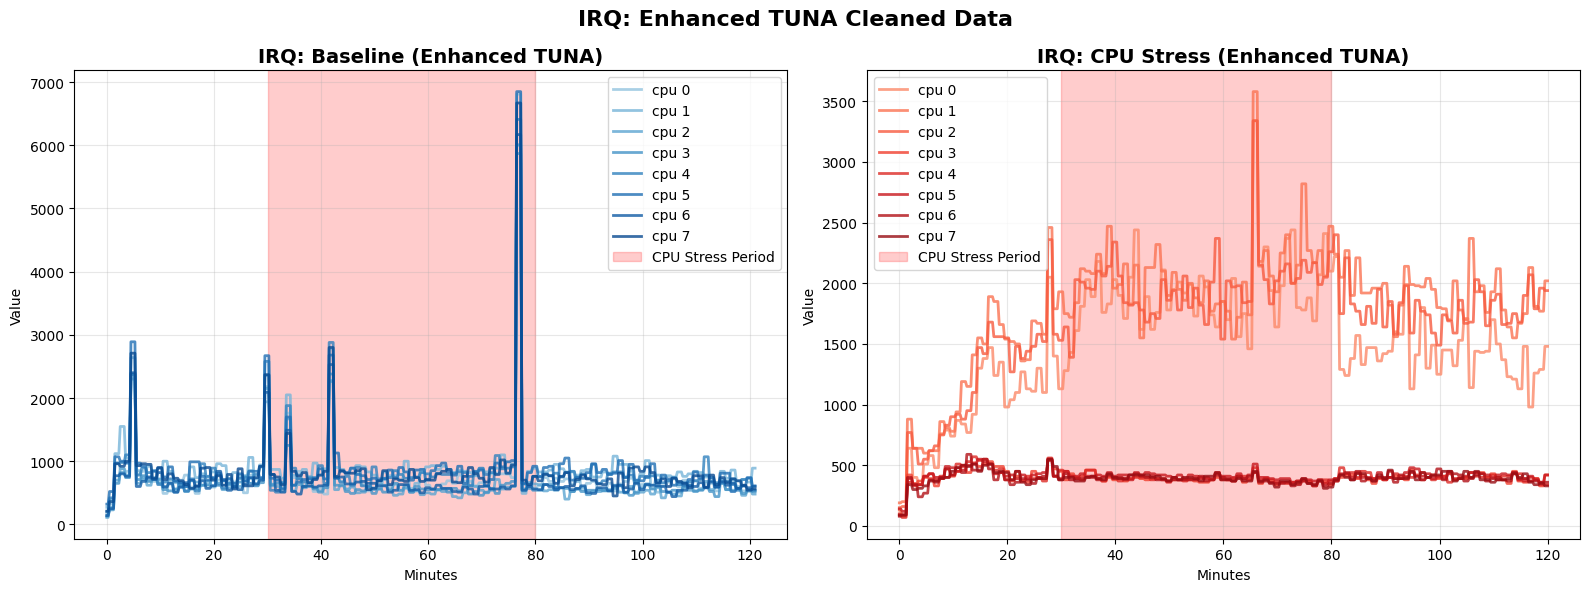

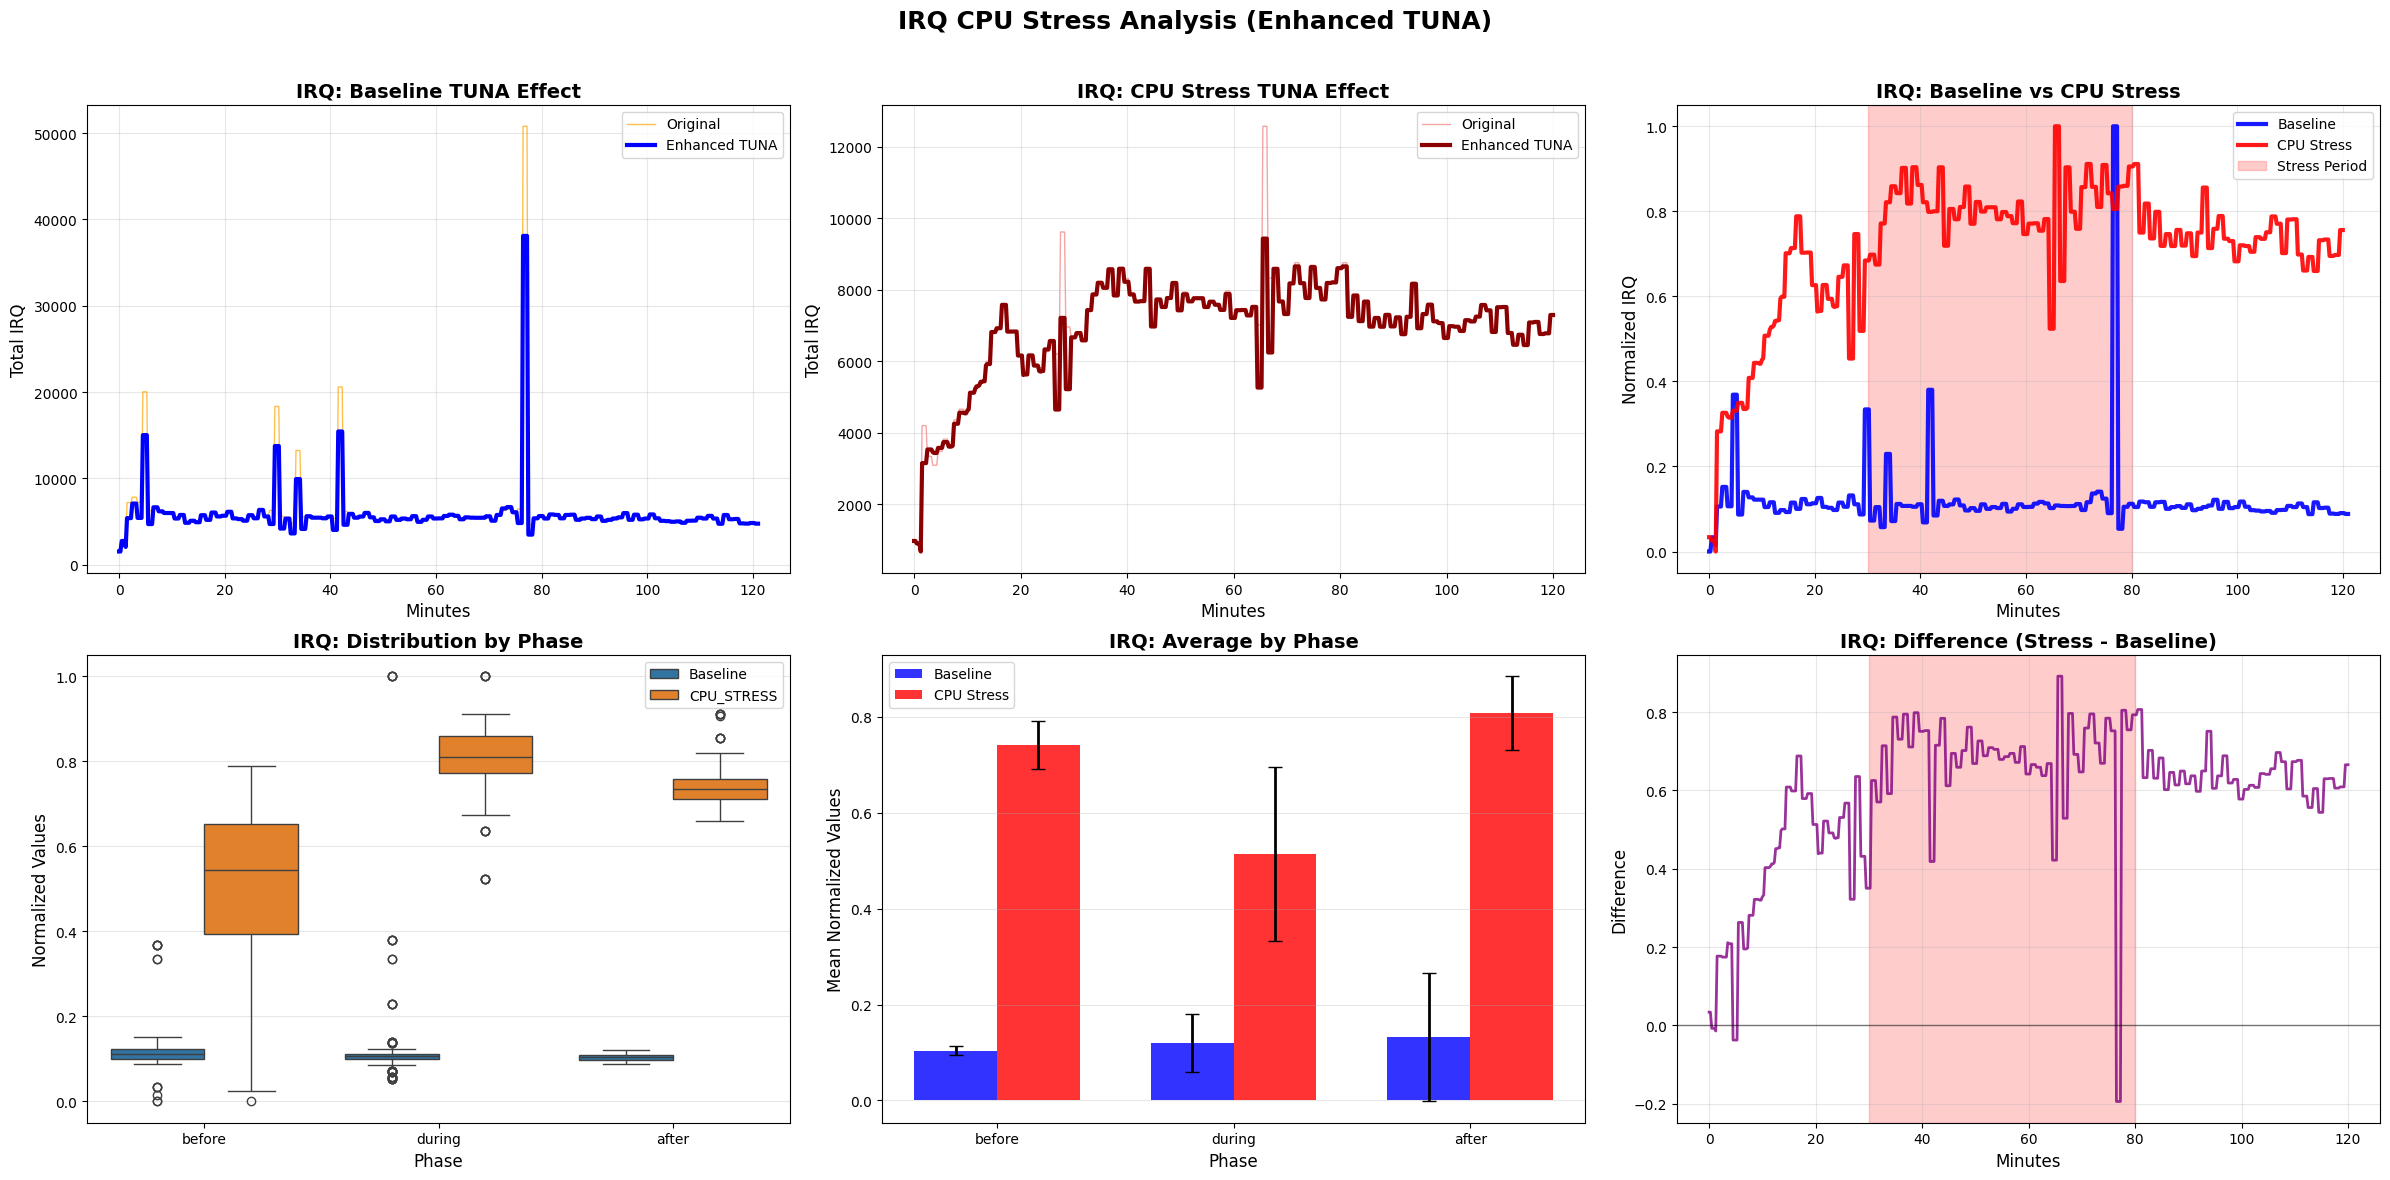

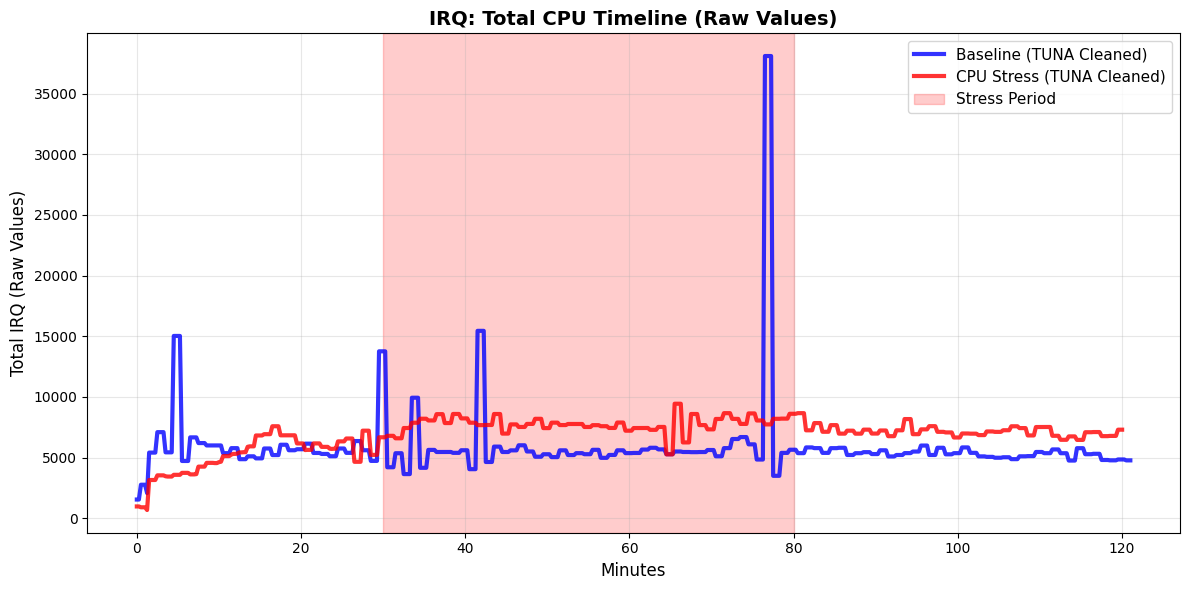


IRQ - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1036  0.0090  0.0879  0.1217
before  0.1191  0.0605  0.0000  0.3688
during  0.1317  0.1339  0.0535  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7422  0.0504  0.6597  0.9113
before  0.5143  0.1819  0.0000  0.7882
during  0.8081  0.0770  0.5240  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-22.59, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-62.08, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-159.63, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  : +331.76% (↗️ INCREASE)
  DURING  : +513.38% (↗️ INCREASE)
  AFTER   : +616.12% (↗️ INCREASE)

🔄 Analyzing System...

📊 Plotting Enhanced TUNA cleaned data for System...


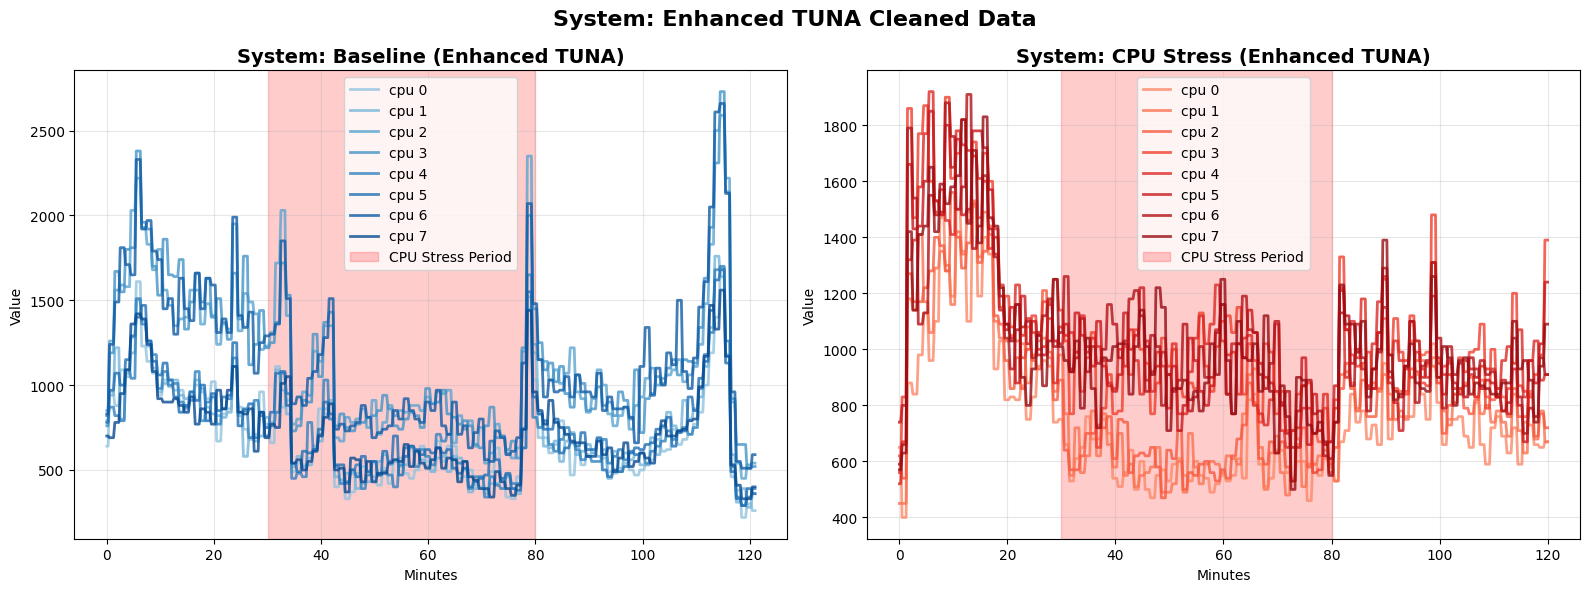

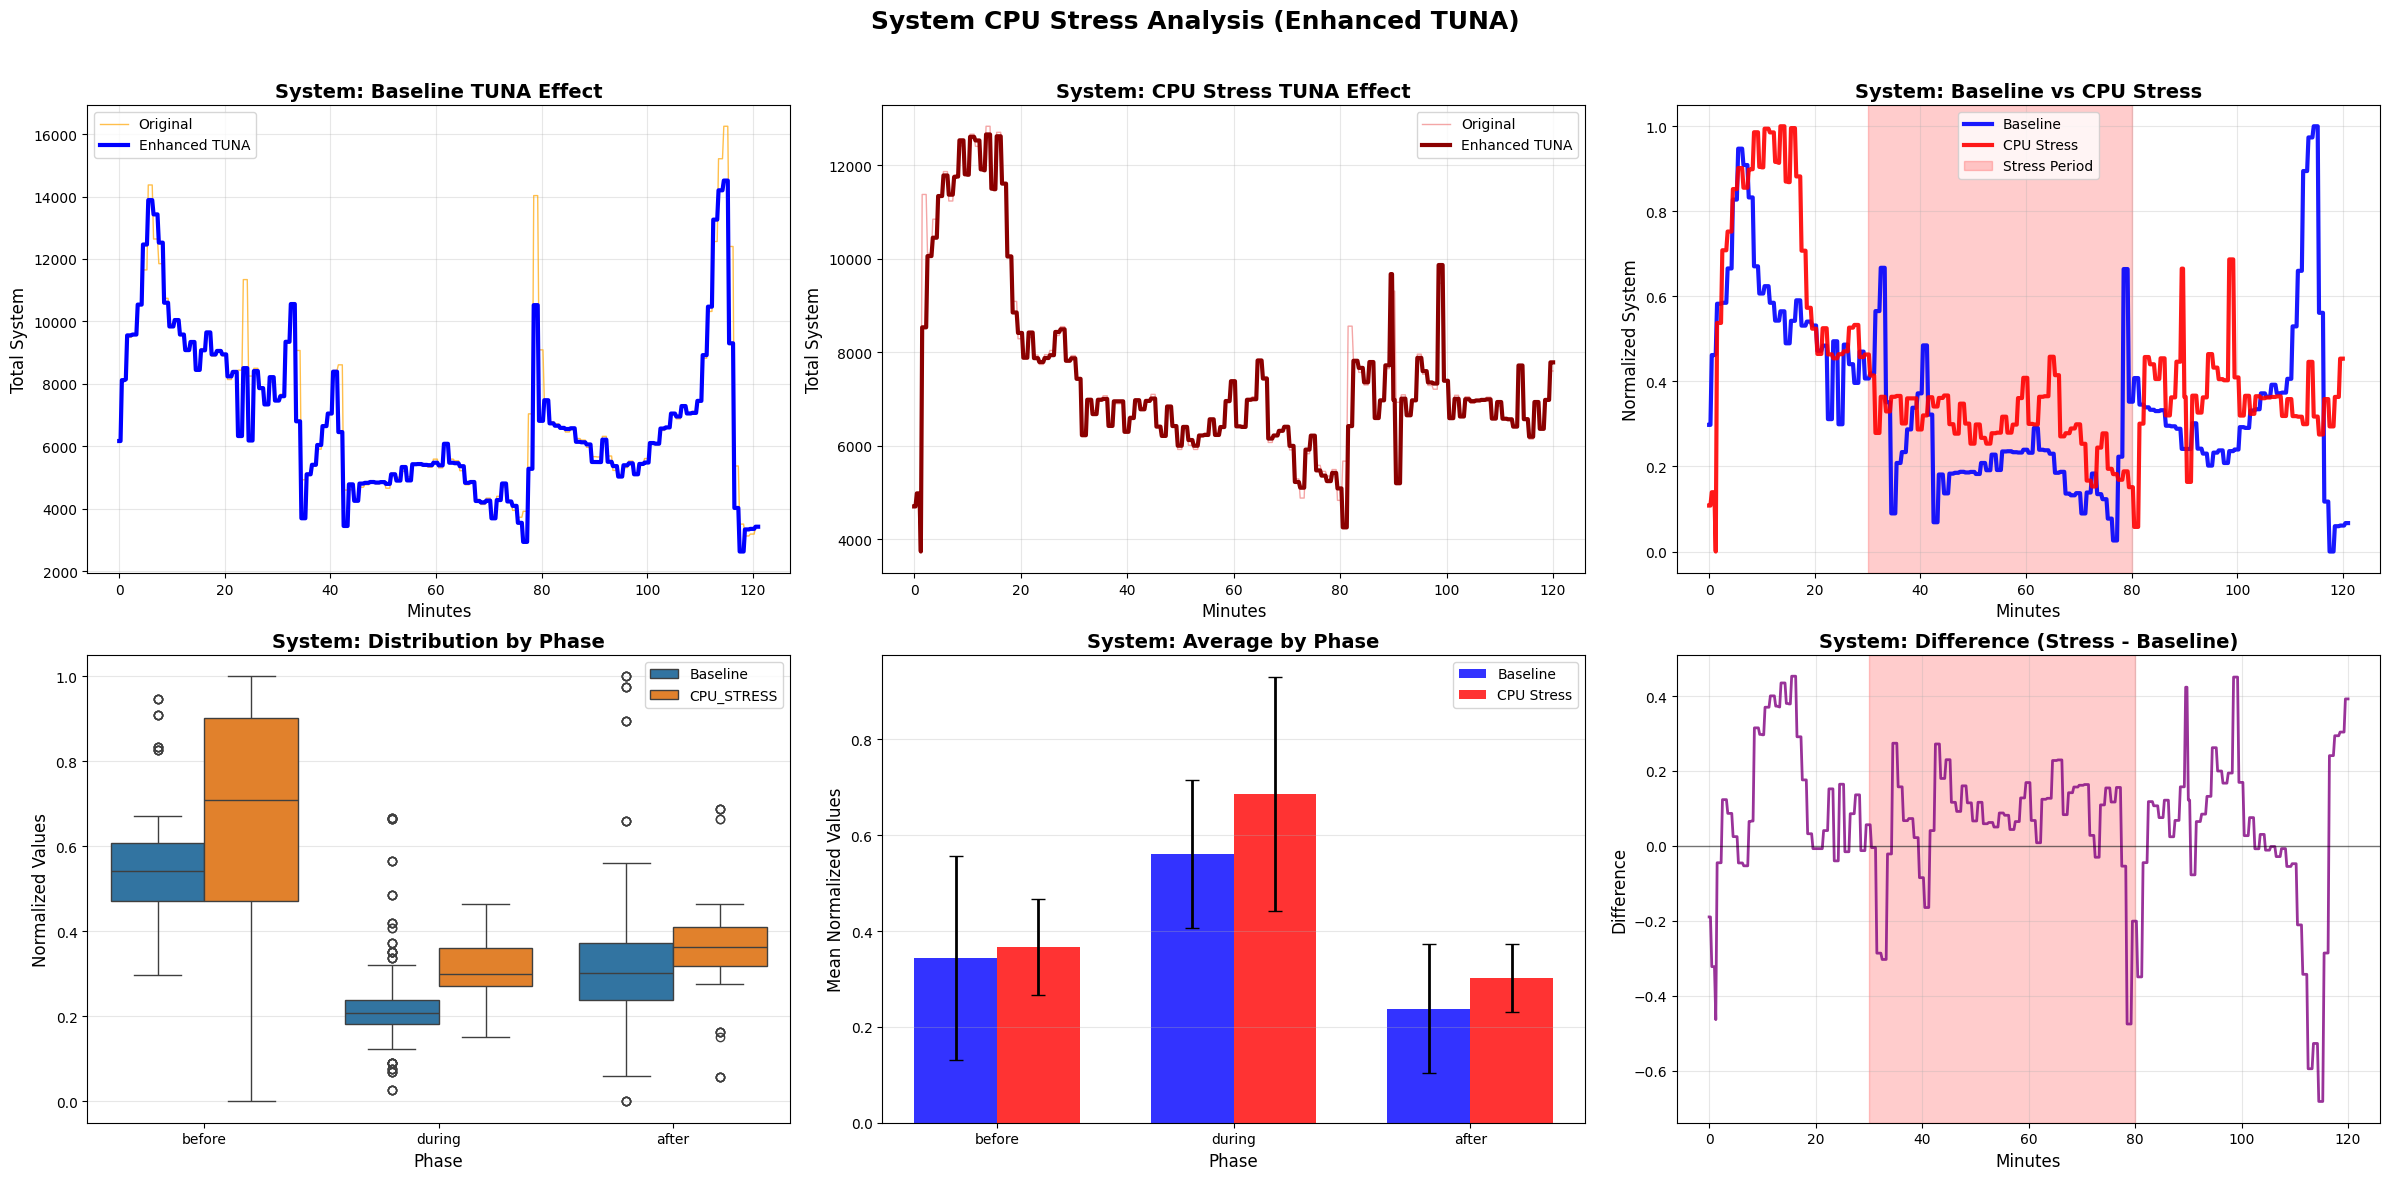

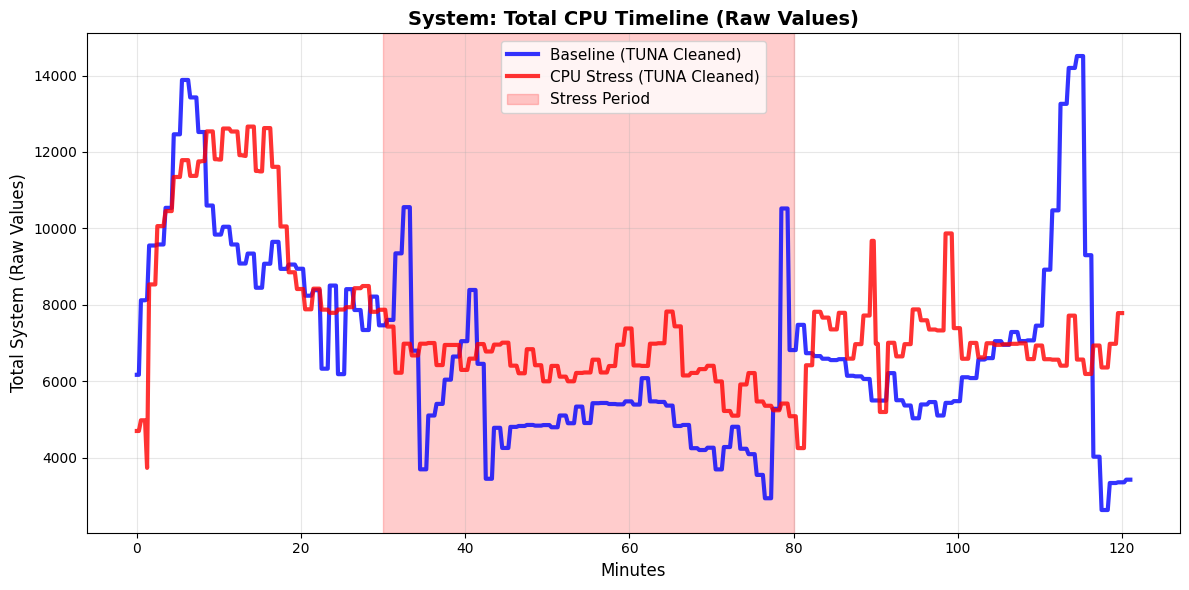


SYSTEM - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3440  0.2135  0.0000  1.0000
before  0.5613  0.1551  0.2978  0.9473
during  0.2381  0.1340  0.0259  0.6671

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3663  0.0997  0.0579  0.6869
before  0.6864  0.2435  0.0000  1.0000
during  0.3027  0.0708  0.1513  0.4633

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -4.75, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -6.03, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -1.20, p=  0.2321 (❌ NOT SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  +22.28% (↗️ INCREASE)
  DURING  :  +27.09% (↗️ INCREASE)
  AFTER   :   +6.47% (↗️ INCREASE)

🔄 Analyzing User...

📊 Plotting Enhanced TUNA cleaned data for User...


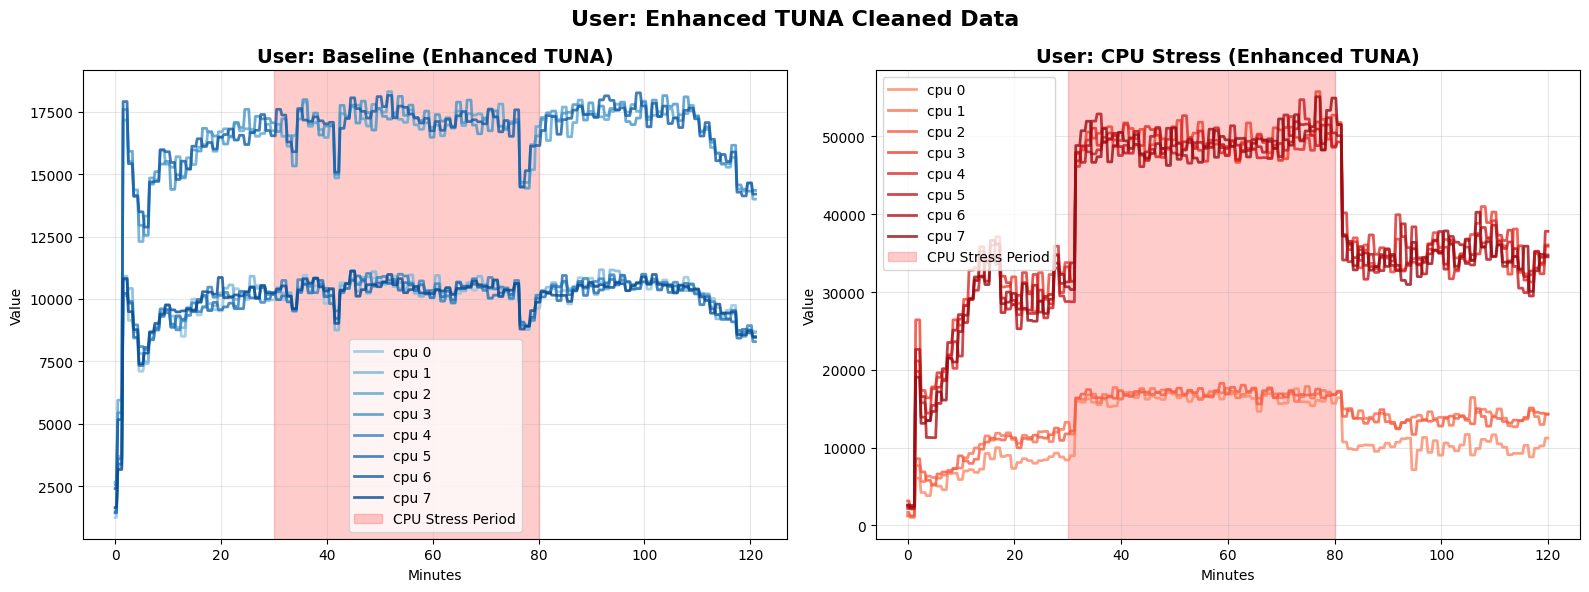

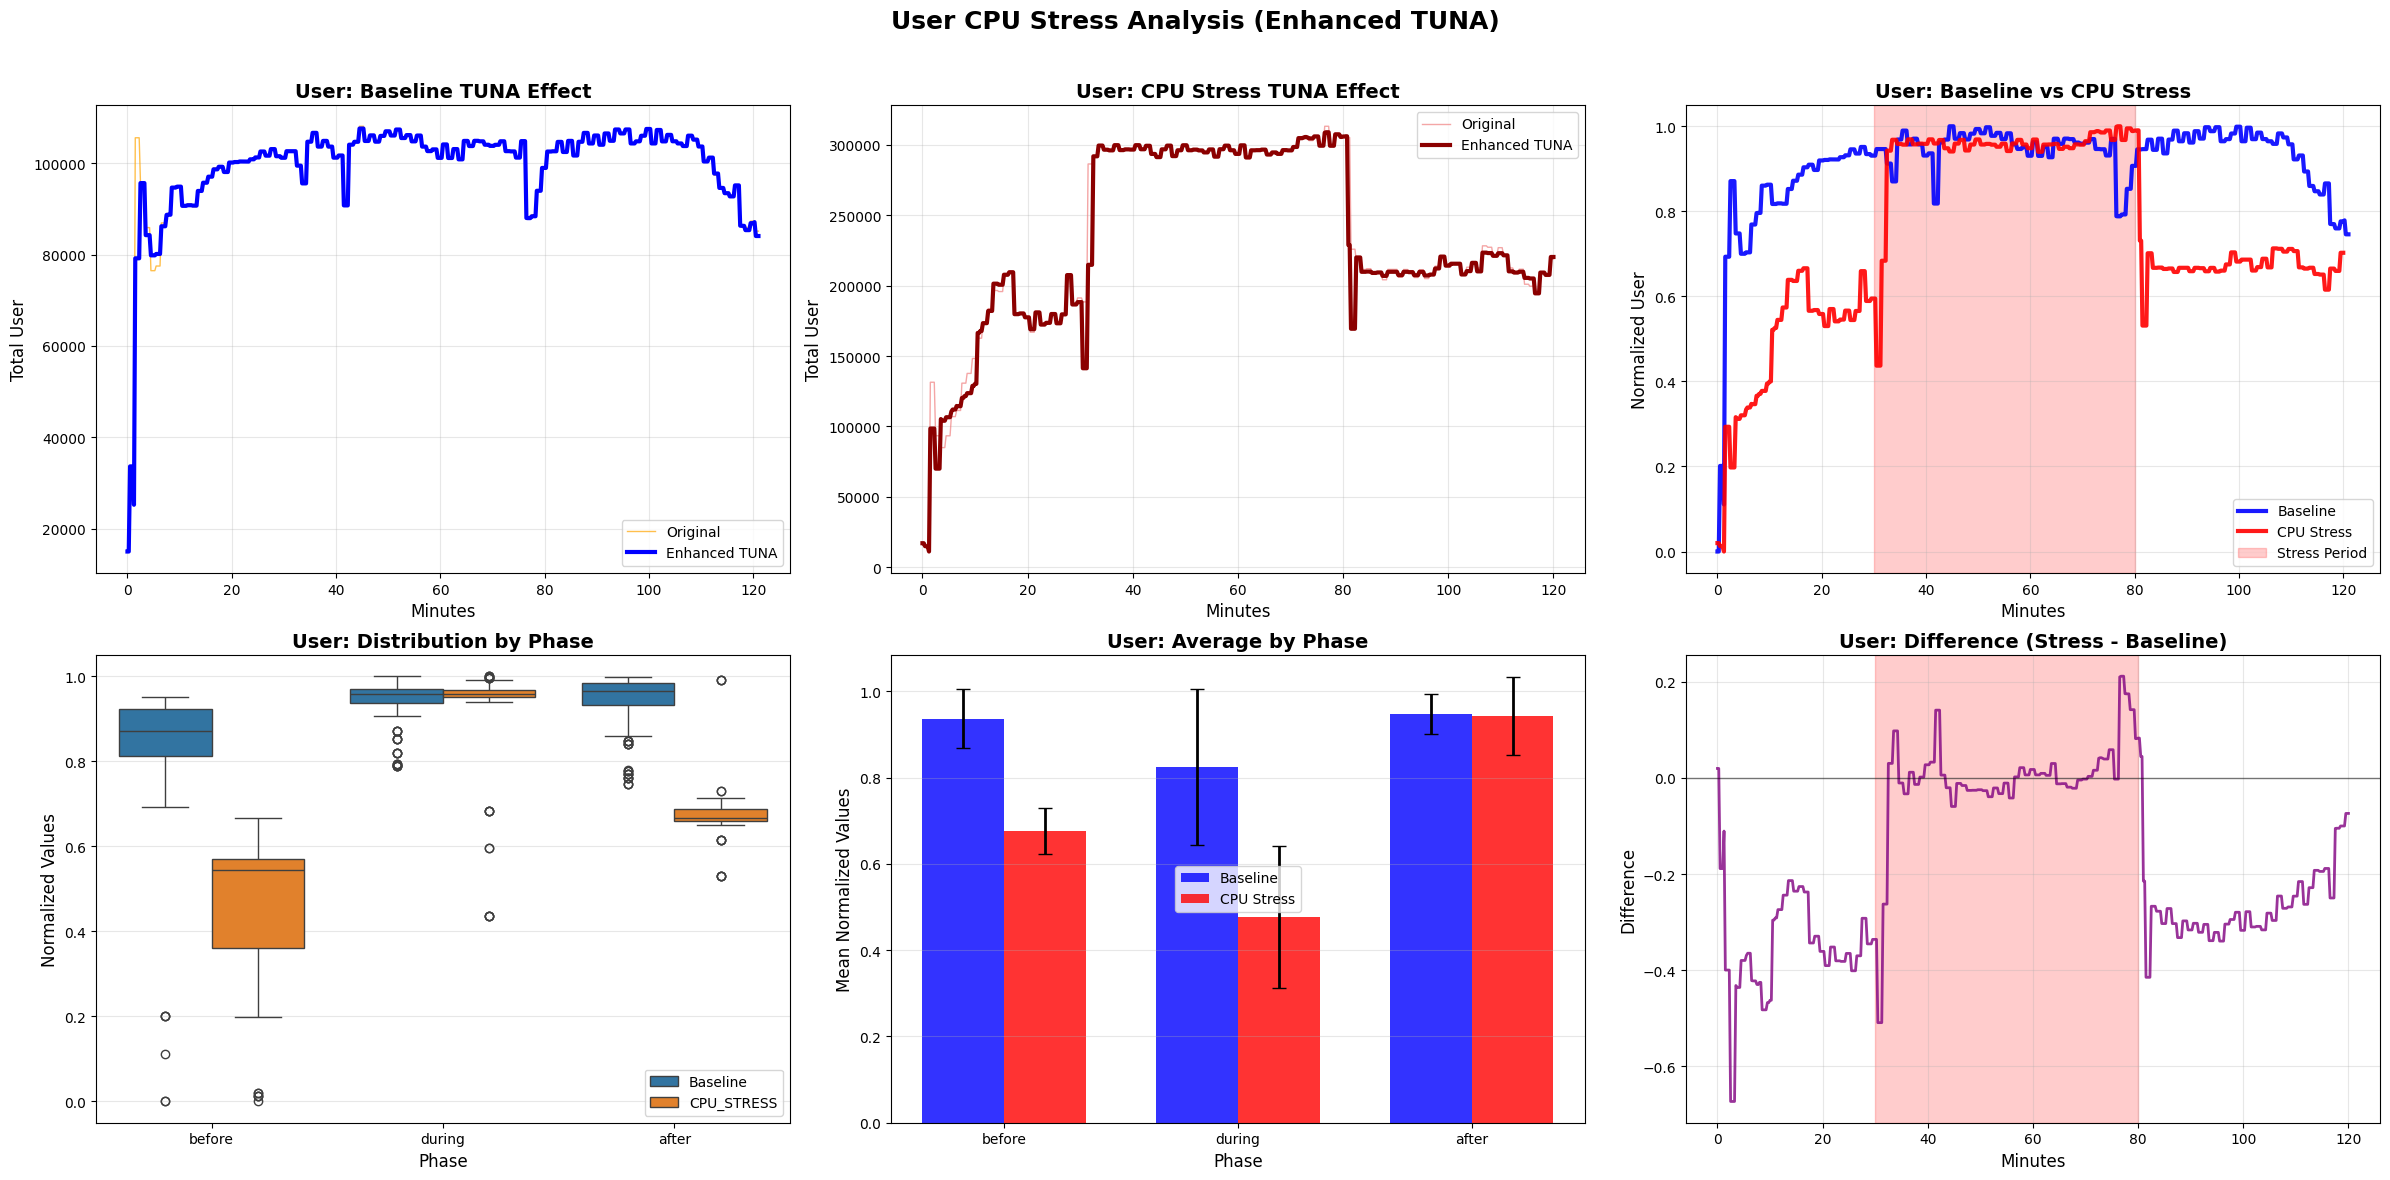

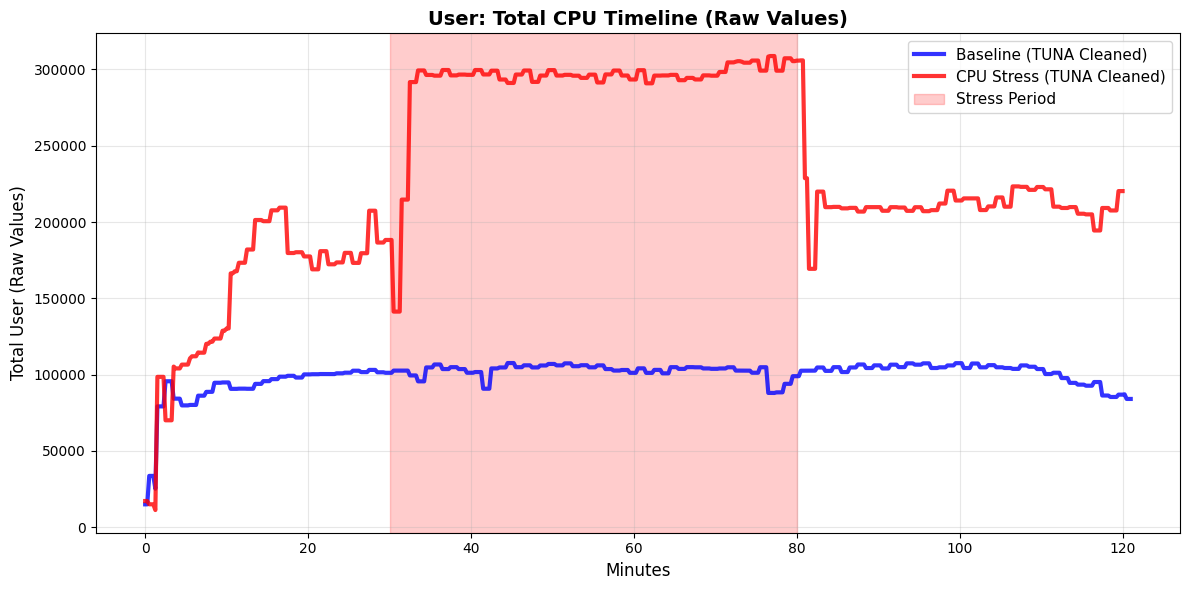


USER - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9370  0.0680  0.7459  0.9990
before  0.8244  0.1803  0.0000  0.9514
during  0.9469  0.0466  0.7882  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6769  0.0532  0.5313  0.9904
before  0.4772  0.1644  0.0000  0.6661
during  0.9424  0.0906  0.4371  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 15.59, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  0.63, p=  0.5309 (❌ NOT SIGNIFICANT)
  AFTER   : t= 38.28, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -42.12% (↘️ DECREASE)
  DURING  :   -0.48% (↘️ DECREASE)
  AFTER   :  -27.76% (↘️ DECREASE)

🔄 Analyzing Utilization...

📊 Plotting Enhanced TUNA cleaned data for Utilization...


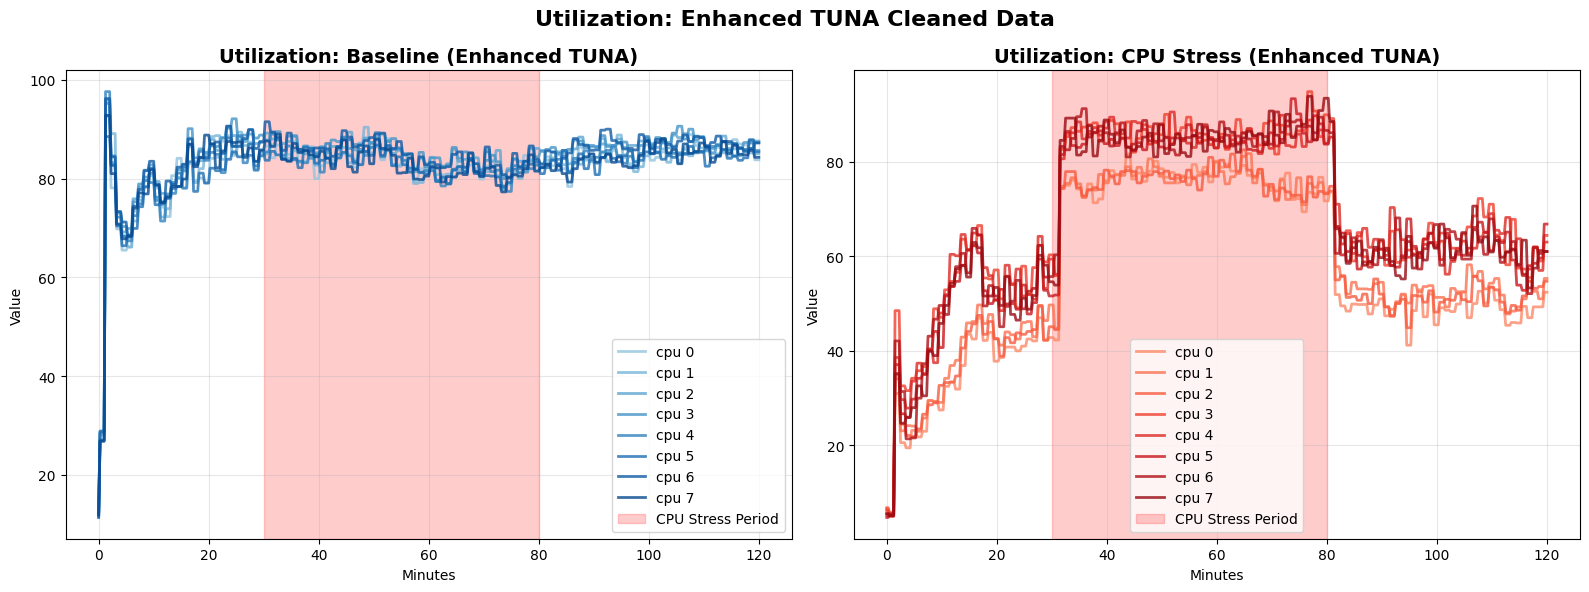

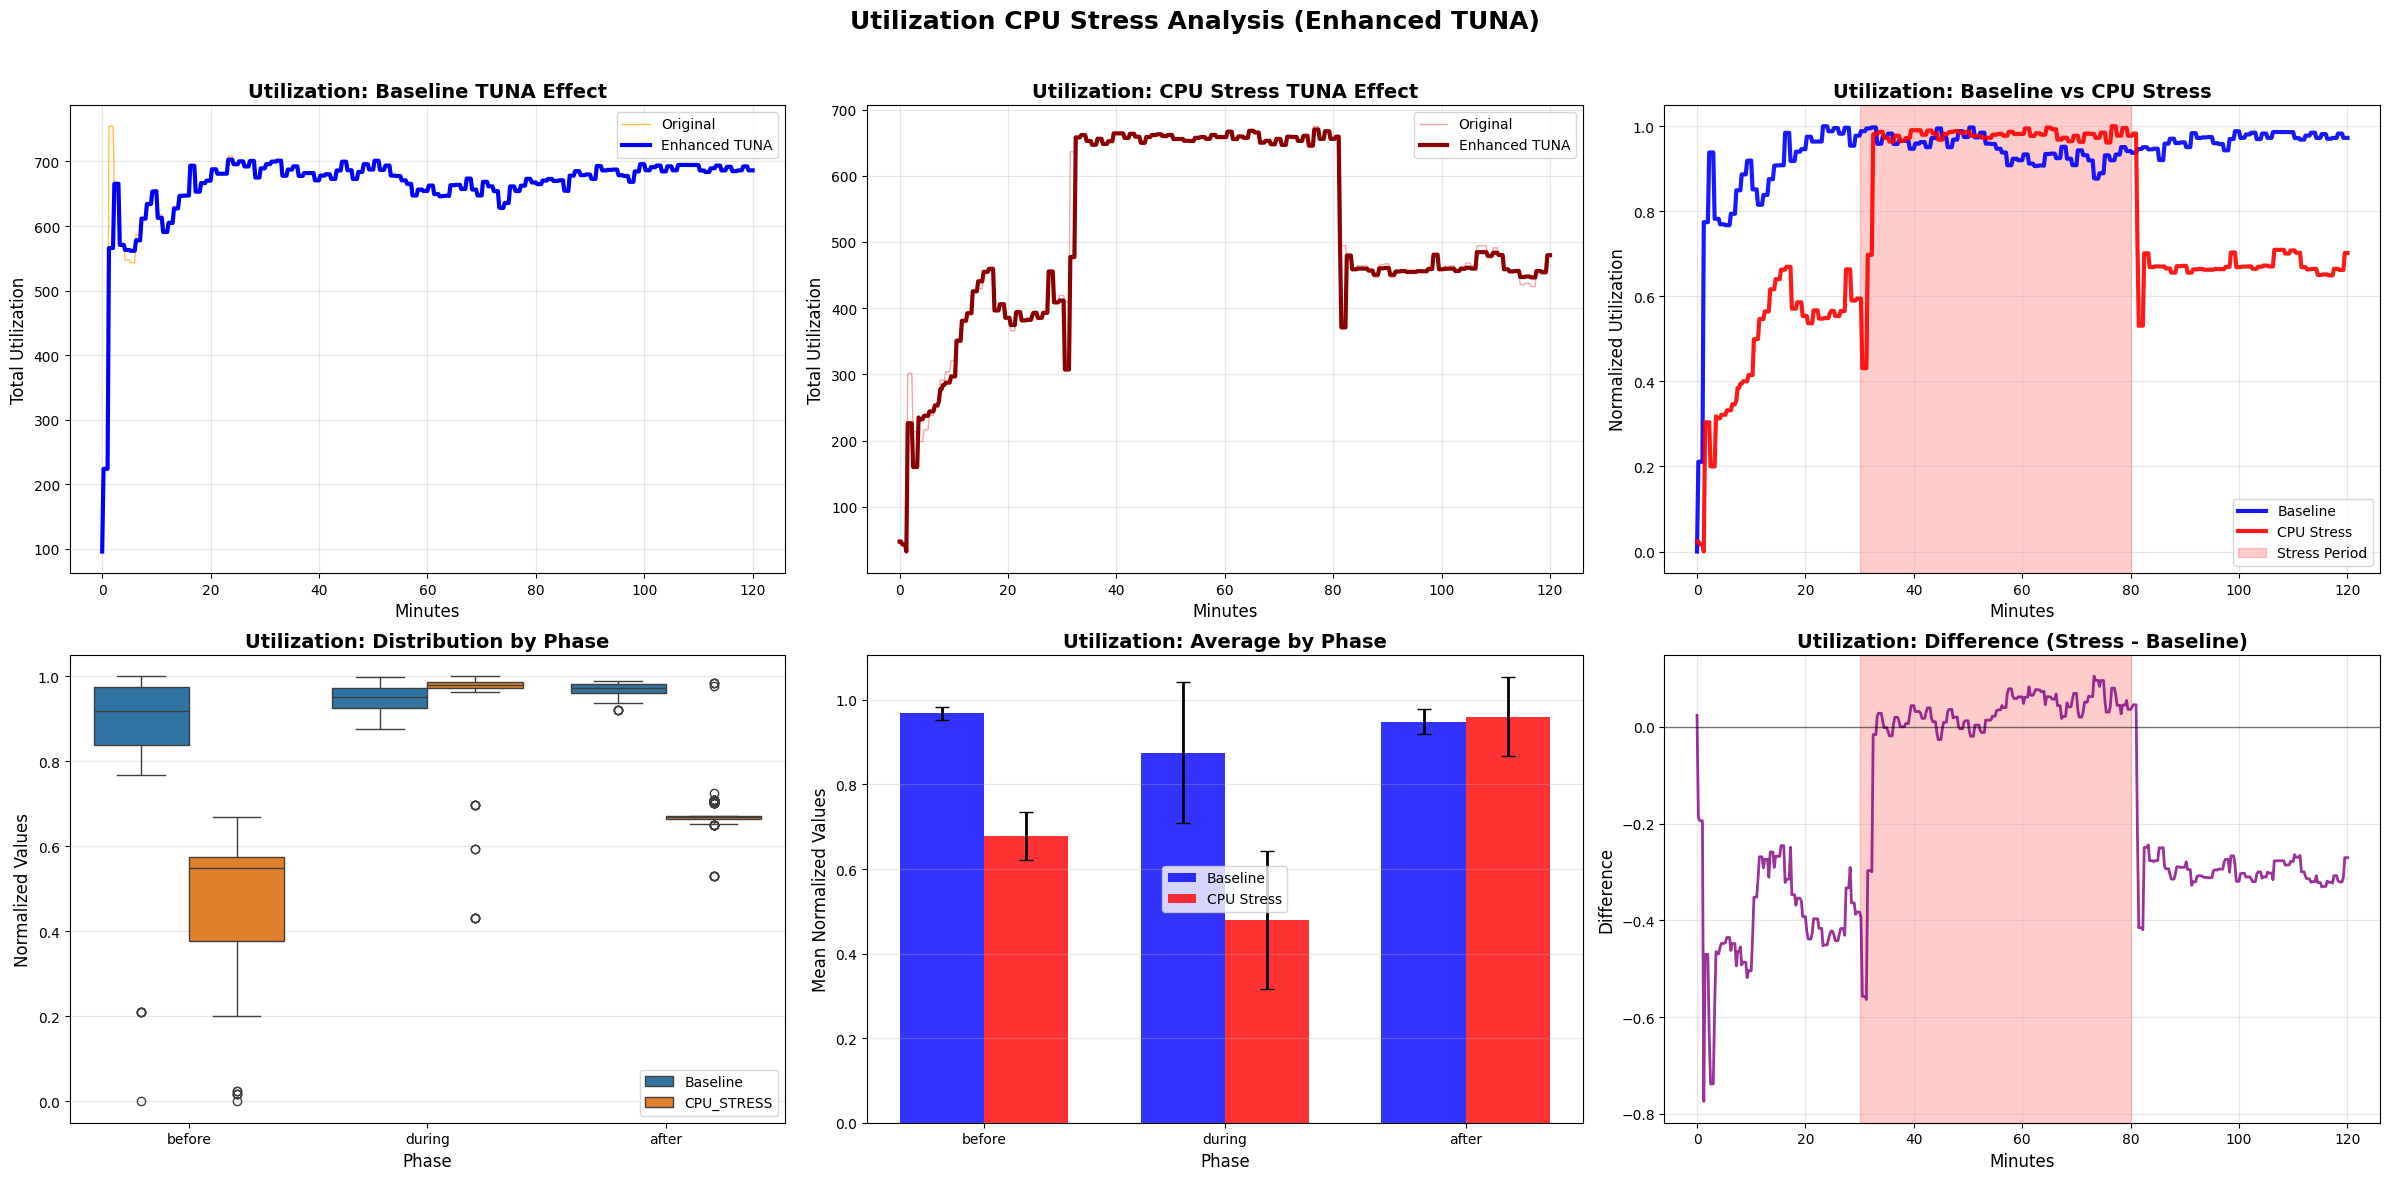

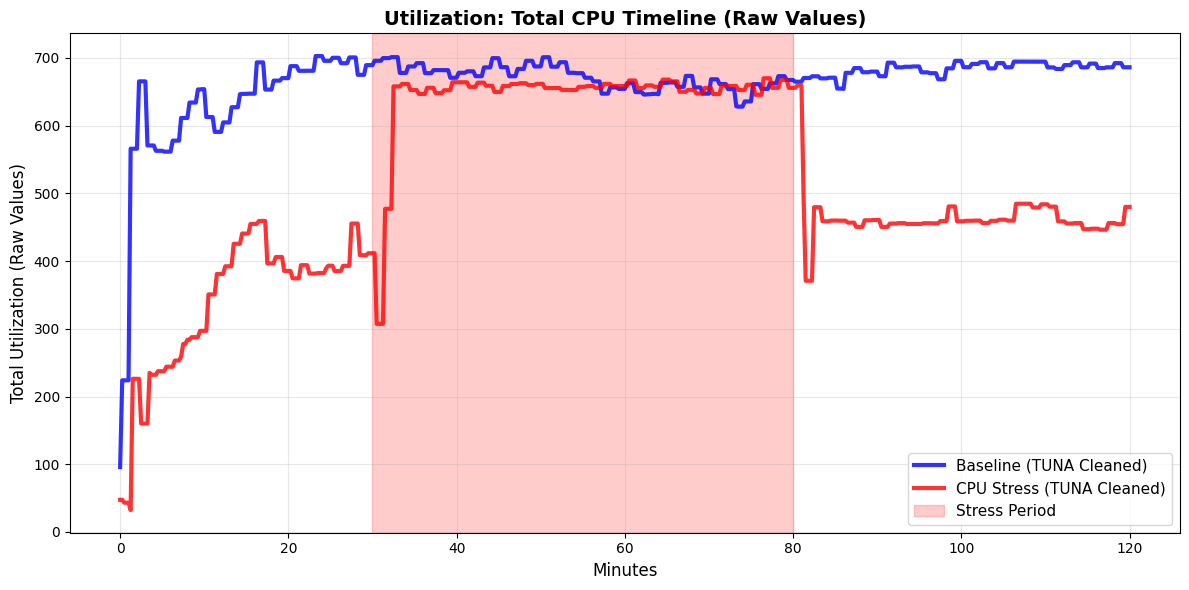


UTILIZATION - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9686  0.0157  0.9200  0.9883
before  0.8744  0.1668  0.0000  1.0000
during  0.9485  0.0290  0.8769  0.9974

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6774  0.0564  0.5311  0.9830
before  0.4798  0.1625  0.0000  0.6695
during  0.9599  0.0937  0.4312  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 18.57, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -1.64, p=  0.1019 (❌ NOT SIGNIFICANT)
  AFTER   : t= 62.90, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -45.13% (↘️ DECREASE)
  DURING  :   +1.20% (↗️ INCREASE)
  AFTER   :  -30.06% (↘️ DECREASE)


In [26]:
# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result


# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df


# PLOT INDIVIDUAL CPU COLUMNS (UPDATED)
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # CPU Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: Enhanced TUNA Cleaned Data', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# MAIN ANALYSIS FUNCTION 
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    print(f"\n📊 Plotting Enhanced TUNA cleaned data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Use TUNA-cleaned Total_CPU_TUNA if available
    if 'Total_CPU_TUNA' in cpu_stress_df.columns:
        cpu_stress_df['Total'] = cpu_stress_df['Total_CPU_TUNA']
        baseline_df['Total'] = baseline_df['Total_CPU_TUNA']
    else:
        cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
        baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals (with safe division)
    cpu_stress_range = cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min()
    baseline_range = baseline_df['Total'].max() - baseline_df['Total'].min()
    
    if cpu_stress_range > 0:
        cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / cpu_stress_range
    else:
        cpu_stress_norm['Total'] = 0
        
    if baseline_range > 0:
        baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / baseline_range
    else:
        baseline_norm['Total'] = 0
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPARISON PLOTS
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline TUNA effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Original', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS TUNA effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='Original', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Difference (Stress - Baseline)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis (Enhanced TUNA)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

    plot_cumulative_cpu_raw(dataset_name, cpu_stress_clean, baseline_clean, delay, duration)
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - ENHANCED TUNA ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

def plot_cumulative_cpu_raw(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot only cumulative CPU timeline (raw values, not normalized)
    """
    
    # Get total CPU values
    stress_total = cpu_stress_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in cpu_stress_df.columns else cpu_stress_df[[col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    baseline_total = baseline_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in baseline_df.columns else baseline_df[[col for col in baseline_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    
    # Single plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(baseline_df['Minutes'], baseline_total, 
             label='Baseline (TUNA Cleaned)', linewidth=3, color='blue', alpha=0.8)
    plt.plot(cpu_stress_df['Minutes'], stress_total, 
             label='CPU Stress (TUNA Cleaned)', linewidth=3, color='red', alpha=0.8)
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    
    plt.title(f'{dataset_name}: Total CPU Timeline (Raw Values)', fontweight='bold', fontsize=14)
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name} (Raw Values)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print simple summary
    baseline_mean = baseline_total.mean()
    stress_mean = stress_total.mean()
    difference = stress_mean - baseline_mean
    percent_change = (difference / baseline_mean) * 100 if baseline_mean != 0 else 0


# RUN ANALYSIS (FIXED)
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )